In [1]:
import graspy
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from graspy.simulations import sbm

n_communities = [50, 50, 50]
p = [[0.5, 0.1, 0.05],
     [0.1, 0.4, 0.15],
     [0.05, 0.15, 0.3],]

np.random.seed(2)
A = sbm(n_communities, p)
from graspy.embed import AdjacencySpectralEmbed

ase = AdjacencySpectralEmbed()
X = ase.fit_transform(A)
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances

In C:\Users\dfran\Miniconda3\envs\ndd_5\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\dfran\Miniconda3\envs\ndd_5\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\dfran\Miniconda3\envs\ndd_5\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\dfran\Miniconda3\envs\ndd_5\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\dfran\Miniconda3\envs\ndd_5\lib\

In [2]:
def _plot_ellipse(
    data, X, j, k, means, covariances, ax, label_palette, cluster_palette, alpha
):
    sns.scatterplot(
        data=data, x=X[:, j], y=X[:, k], ax=ax, hue="labels", palette=label_palette
    )
    means_collector = data[[j, k, "labels"]]   
    means_collector = means_collector.groupby("labels").mean()
    lst_tups = list(zip(means_collector[j], means_collector[k]))
    means_list = [[i[0], i[1]] for i in lst_tups]
    distance_arr = euclidean_distances(np.asarray(means_list), means[:, [j, k]])
    for i, (mean, covar) in enumerate(zip(means, covariances)):
        min_inds = np.argwhere(distance_arr[i] == np.min(distance_arr[i]))
        ind = min_inds[0,0]
        min_block_name = list(means_collector.index)[ind]
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi
        ell = mpl.patches.Ellipse(
            [mean[j], mean[k]],
            v[0],
            v[1],
            180.0 + angle,
            color=cluster_palette[min_block_name],
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(alpha)
        ax.add_artist(ell)
        ax.set_xticks([]), ax.set_yticks([])
        ax.set_ylabel(k), ax.set_xlabel(k)


def pairplot_with_gmm(
    X,
    gmm,
    labels=None,
    cluster_palette=None,
    label_palette=None,
    title=None,
    context="talk",
    font_scale=1,
    alpha=0.7,
):
    r"""
    Plot pairwise relationships in a dataset.
    By default, this function will create a grid of Axes such that each
    dimension in data will by shared in the y-axis across a single row and
    in the x-axis across a single column.

    Parameters
    ----------
    X : np.ndarray (2D)
        input graph
    gmm: Gaussian Mixture Model object
    labels : 1d np.ndarray or list, same length as dimensions of X
        Labels for different categories of graph nodes
    label_palette : str or dict, optional, default: dictionary using 'Set1'
    cluster_palette : str or dict, optional, default: dictionary using 'Set1'
    title : string, default : 'Degree plot'
        Plot title
    context :  None, or one of {talk (default), paper, notebook, poster}
        Seaborn plotting context
    font_scale : float, optional, default: 1
        Separate scaling factor to independently scale the size of the font
        elements.
    alpha : float, optional, default: 0.7
        Opacity value of plotter markers between 0 and 1
    """
    # Handle X
    if not isinstance(X, (list, np.ndarray)):
        msg = "X must be array-like, not {}.".format(type(X))
        raise TypeError(msg)

    # Handle labels
    if labels is not None:
        if not isinstance(labels, (list, np.ndarray)):
            msg = "Y must be array-like or list, not {}.".format(type(labels))
            raise TypeError(msg)
        elif X.shape[0] != len(labels):
            msg = "Expected length {}, but got length {} instead for Y.".format(
                X.shape[0], len(labels)
            )
            raise ValueError(msg)
    # Handle gmm
    if gmm is None:
        msg = "You must input a sklearn.mixture.GaussianMixture"
        raise NameError(msg)
    Y_, means, covariances = gmm.predict(X), gmm.means_, gmm.covariances_
    data = pd.DataFrame(data=X)
    num_comps = gmm.n_components
    if labels is None:
        lab_names = ["Block {}".format(i) for i in range(num_comps)]
        data["labels"] = np.asarray([lab_names[Y_[i]] for i in range(Y_.shape[0])])
    else:
        data["labels"] = labels
    data["clusters"] = Y_
    if isinstance(cluster_palette, str) and labels is not None:
        colors = sns.color_palette(cluster_palette, num_comps)
        cluster_palette = dict(zip(np.unique(Y_), colors))
    if isinstance(label_palette, str) and labels is not None:
        colors = sns.color_palette(label_palette, num_comps)
        label_palette = dict(zip(np.unique(np.asarray(labels)), colors))
    if (labels is not None) and (cluster_palette is None or label_palette is None):
        msg = "if give labels array must give palette dicts or string desciptors"
        raise ValueError(msg)
    elif labels is None and cluster_palette is None and label_palette is None:
        colors = sns.color_palette("Set1", num_comps)
        cluster_palette = dict(zip(np.unique(lab_names), colors))
        label_palette = dict(zip(np.unique(lab_names), colors))
    elif labels is None and (cluster_palette is not None or label_palette is not None):
        msg = "must give labels if using palettes for labels and clusters"
        raise ValueError(msg)
    with sns.plotting_context(context=context, font_scale=font_scale):
        if X.shape[1] == 2:
            pairplot, axes = plt.subplots(1, 1, figsize=(12, 12))
            _plot_ellipse(
                data,
                X,
                0,
                1,
                means,
                covariances,
                axes,
                label_palette,
                cluster_palette,
                alpha=alpha,
            )
            axes.set_ylabel("Dim " + str(0))
            axes.set_xlabel("Dim " + str(1))
            axes.label_outer()
            axes.spines["right"].set_visible(False)
            axes.spines["top"].set_visible(False)
            if title:
                pairplot.suptitle(title)
            else:
                pairplot.suptitle(
                    "Fit a Gaussian mixture using "
                    + str(means.shape[0])
                    + " components"
                )
            return
        pairplot, axes = plt.subplots(X.shape[1], X.shape[1], figsize=(12, 12))
        for k in range(X.shape[1]):
            for j in range(X.shape[1]):
                if k == j:
                    for t, lab in zip([i for i in range(X.shape[1])], label_palette):
                        sns.distplot(
                            X[Y_ == t, k],
                            kde=True,
                            ax=axes[k, k],
                            color=label_palette[lab],
                        )
                    axes[k, j].set_xticks([]), axes[k, j].set_yticks([])
                    axes[k, j].set_ylabel(None)
                    axes[k, j].set_ylabel(j), axes[k, j].set_xlabel(k)
                else:
                    _plot_ellipse(
                        data,
                        X,
                        j,
                        k,
                        means,
                        covariances,
                        axes[k, j],
                        label_palette,
                        cluster_palette,
                        alpha=alpha,
                    )
        for i in range(X.shape[1]):
            for j in range(X.shape[1]):
                axes[i, j].set_ylabel("Dim " + str(i))
                axes[i, j].set_xlabel("Dim " + str(j))
        if title:
            pairplot.suptitle(title)
        else:
            pairplot.suptitle(
                "Fit a Gaussian mixture using " + str(means.shape[0]) + " components"
            )
        handles, labels = [], []
        for ax in axes.flat:
            ax.label_outer()
            ax.spines["right"].set_visible(False)
            ax.spines["top"].set_visible(False)
            ax.legend().remove()
            handles_, labels_ = ax.get_legend_handles_labels()
            handles += handles_
            labels += labels_

        pairplot.legend(
            handles[: means.shape[0]], labels[: means.shape[0]], loc="upper right"
        )

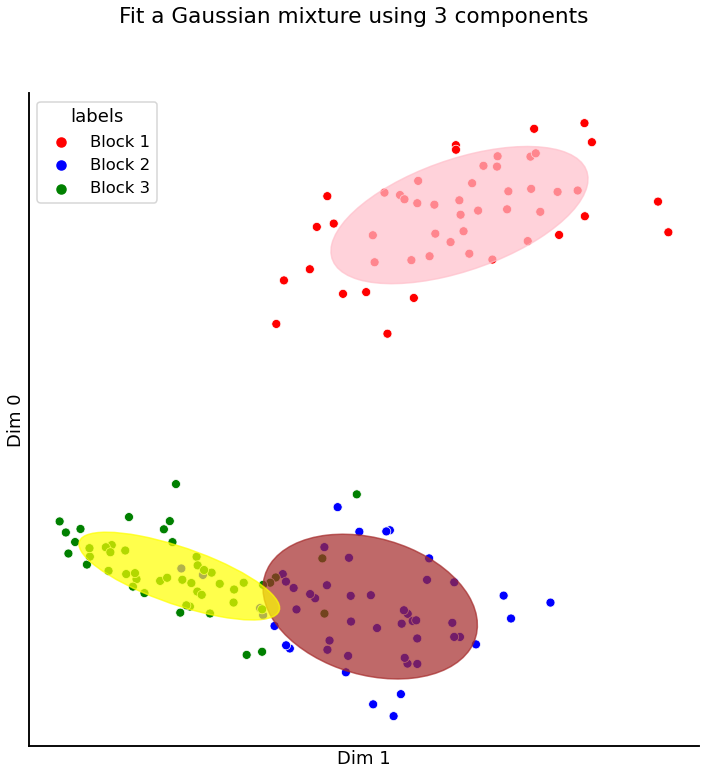

In [3]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, covariance_type='full').fit(X[:, :2])

labels = ['Block 1'] * 50 + ['Block 2'] * 50 + ['Block 3'] * 50
cluster_palette = {"Block 1": 'pink', "Block 2": 'brown', "Block 3": 'yellow'}
label_palette = {"Block 1": 'red', 'Block 2':'blue', 'Block 3': 'green'}
pairplot_with_gmm(X[:,:2], gmm, labels = labels, cluster_palette = cluster_palette,  label_palette = label_palette)
#pairplot_with_gmm(X[:, :2], gmm, labels = None, cluster_palette = None,  label_palette = None)

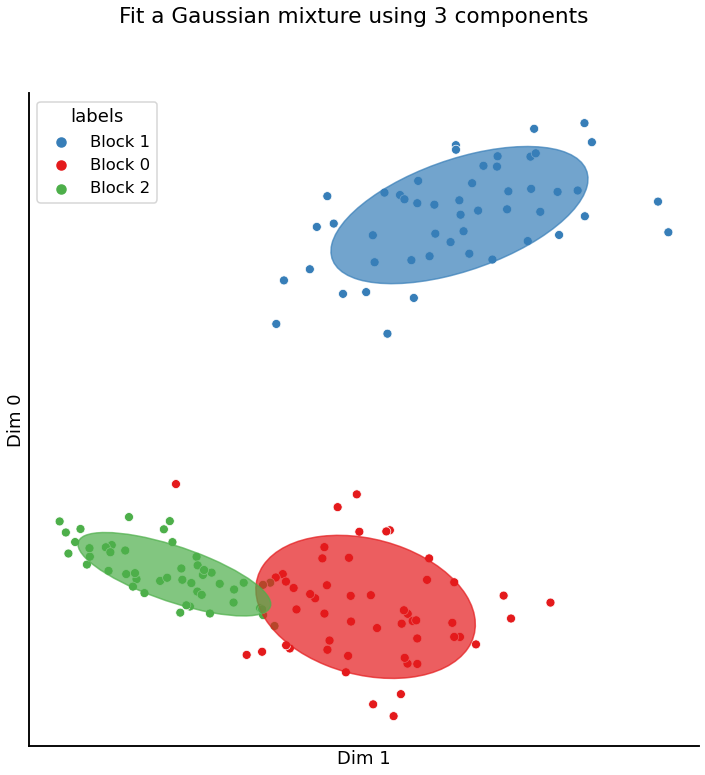

In [4]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, covariance_type='full').fit(X[:, :2])

labels = ['Block 1'] * 50 + ['Block 2'] * 50 + ['Block 3'] * 50
cluster_palette = {"Block 1": 'pink', "Block 2": 'brown', "Block 3": 'yellow'}
label_palette = {"Block 1": 'red', 'Block 2':'blue', 'Block 3': 'green'}
#pairplot_with_gmm(X[:,:2], gmm, labels = labels, cluster_palette = cluster_palette,  label_palette = label_palette)
pairplot_with_gmm(X[:, :2], gmm, labels = None, cluster_palette = None,  label_palette = None)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


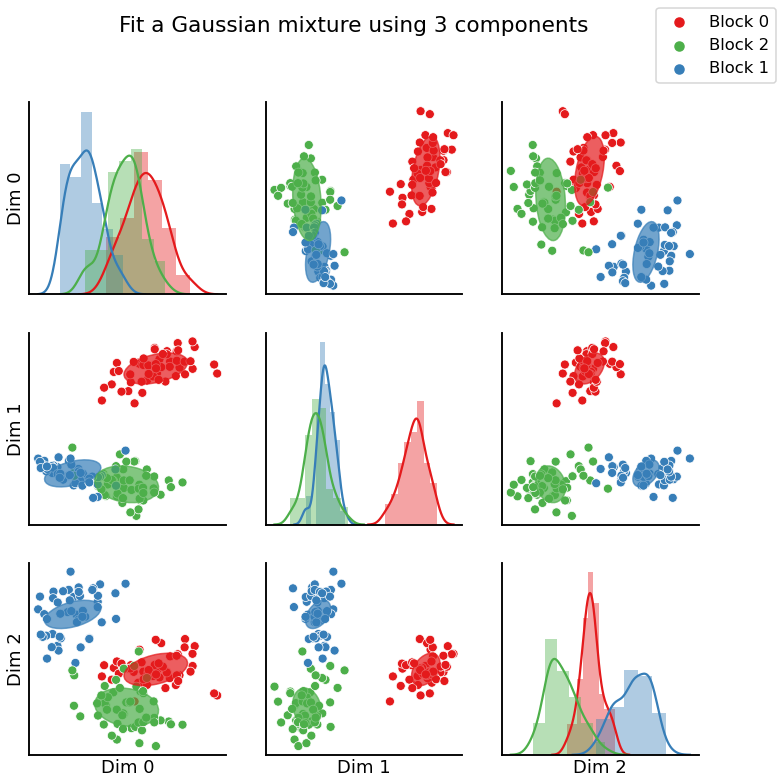

In [5]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, covariance_type='full').fit(X)

labels = ['Block 1'] * 50 + ['Block 2'] * 50 + ['Block 3'] * 50
cluster_palette = {"Block 1": 'pink', "Block 2": 'brown', "Block 3": 'yellow'}
label_palette = {"Block 1": 'red', 'Block 2':'blue', 'Block 3': 'green'}
#pairplot_with_gmm(X[:,:2], gmm, labels = labels, cluster_palette = cluster_palette,  label_palette = label_palette)
pairplot_with_gmm(X, gmm, labels = None, cluster_palette = None,  label_palette = None)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


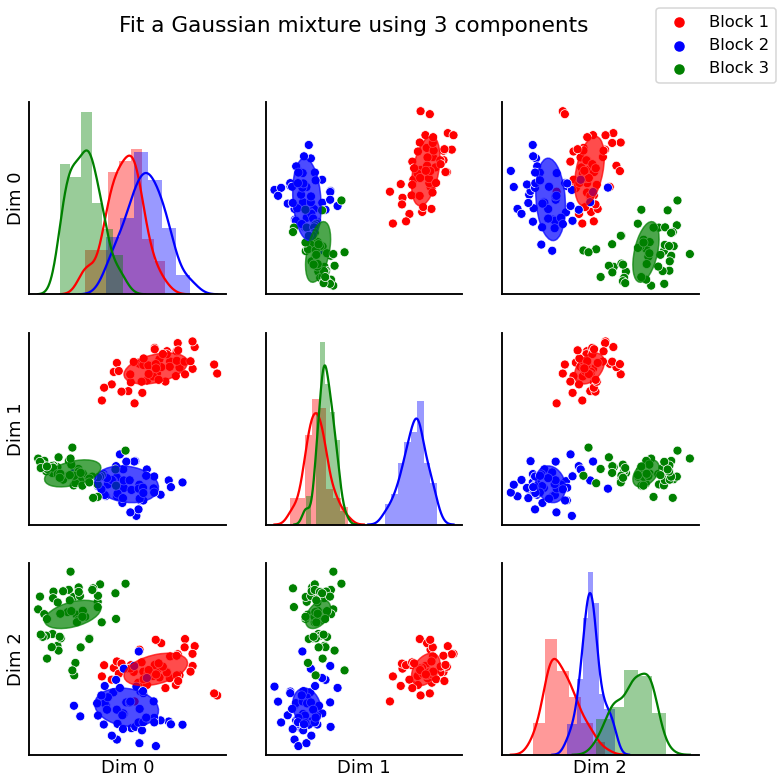

In [7]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, covariance_type='full').fit(X)

labels = ['Block 1'] * 50 + ['Block 2'] * 50 + ['Block 3'] * 50
cluster_palette = {"Block 1": 'red', 'Block 2':'blue', 'Block 3': 'green'}
label_palette = {"Block 1": 'red', 'Block 2':'blue', 'Block 3': 'green'}
pairplot_with_gmm(X, gmm, labels = labels, cluster_palette = cluster_palette,  label_palette = label_palette)
#pairplot_with_gmm(X, gmm, labels = None, cluster_palette = None,  label_palette = None)